In [1]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tf.multiply(tensor, 255)
    print(f"{tensor.shape=}")
    tensor = np.array(tensor[0], dtype=np.uint8)
    if np.ndim(tensor)>3:
        print(f"{tensor.shape=}")
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = '/home/steffanic/Projects/style_transfer_imgs/Brittney_content.png'
style_path = '/home/steffanic/Projects/style_transfer_imgs/floral_style.png'

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

(1, 512, 409, 3)
(1, 512, 347, 3)


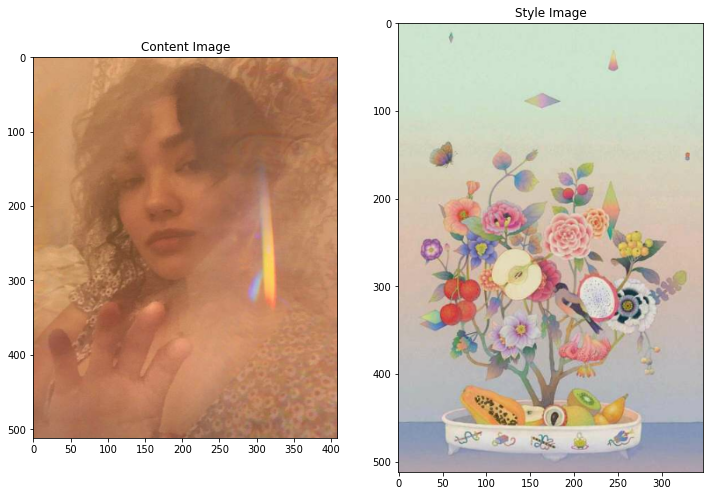

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
print(content_image.shape)

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
print(style_image.shape)

tensor.shape=TensorShape([1, 1, 512, 412, 3])
tensor.shape=(1, 512, 412, 3)


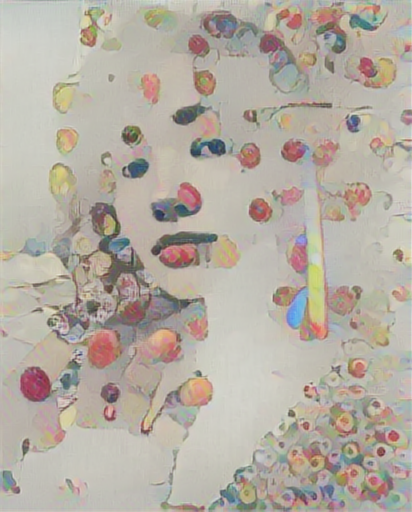

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))
tensor_to_image(stylized_image)

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('tub', 0.19187486),
 ('torch', 0.11640174),
 ('bathtub', 0.100344665),
 ('candle', 0.048983973),
 ('shower_cap', 0.04632131)]

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layers = ['block5_conv2', 'block4_conv4']

style_layers = ['block1_conv1',
                'block2_conv2',
                'block3_conv3', 
                'block4_conv1',
                'block5_conv1']

'''['block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']'''

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(f"  shape: {output.numpy().shape}")
    print(f"  min: {output.numpy().min()}")
    print(f"  max: {output.numpy().max()}")
    print(f"  mean: {output.numpy().mean()}")
    print()
    


block1_conv1
  shape: (1, 512, 347, 64)
  min: 0.0
  max: 757.6199951171875
  mean: 30.70968246459961

block2_conv2
  shape: (1, 256, 173, 128)
  min: 0.0
  max: 6527.62060546875
  mean: 140.6433868408203

block3_conv3
  shape: (1, 128, 86, 256)
  min: 0.0
  max: 8577.591796875
  mean: 369.12841796875

block4_conv1
  shape: (1, 64, 43, 512)
  min: 0.0
  max: 18178.23046875
  mean: 522.6810302734375

block5_conv1
  shape: (1, 32, 21, 512)
  min: 0.0
  max: 3408.331298828125
  mean: 40.05910110473633



In [15]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

In [16]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        'Expects float input in [0,1]'
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style': style_dict}

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print(f"  {name}")
    print(f"   shape: {output.numpy().shape}")
    print(f"   min: {output.numpy().min()}")
    print(f"   max: {output.numpy().max()}")
    print(f"   mean: {output.numpy().mean()}")
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print(f"  {name}")
    print(f"   shape: {output.numpy().shape}")
    print(f"   min: {output.numpy().min()}")
    print(f"   max: {output.numpy().max()}")
    print(f"   mean: {output.numpy().mean()}")

Styles:
  block1_conv1
   shape: (1, 64, 64)
   min: 0.0
   max: 10900.564453125
   mean: 243.37466430664062

  block2_conv2
   shape: (1, 128, 128)
   min: 0.2684886157512665
   max: 70162.703125
   mean: 2326.356201171875

  block3_conv3
   shape: (1, 256, 256)
   min: 173.0842742919922
   max: 581521.0625
   mean: 27475.51953125

  block4_conv1
   shape: (1, 512, 512)
   min: 0.0
   max: 1096337.0
   mean: 54198.1484375

  block5_conv1
   shape: (1, 512, 512)
   min: 0.0
   max: 13782.3173828125
   mean: 244.28549194335938

Contents:
  block4_conv4
   shape: (1, 64, 51, 512)
   min: 0.0
   max: 1704.4791259765625
   mean: 14.214276313781738
  block5_conv2
   shape: (1, 32, 25, 512)
   min: 0.0
   max: 460.66278076171875
   mean: 5.834610462188721


In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
image = tf.Variable(content_image)

In [20]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max=1.0)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
style_weight=1
content_weight=1e4
total_variation_weight=30

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers 
    loss = style_loss + content_loss
    return loss

In [24]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

tensor.shape=TensorShape([1, 512, 409, 3])


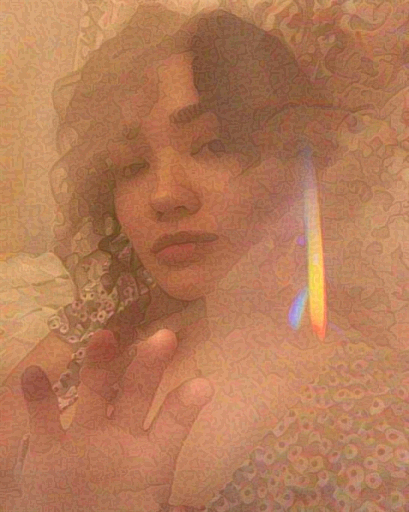

In [25]:
train_step(image)
tensor_to_image(image)

tensor.shape=TensorShape([1, 512, 409, 3])


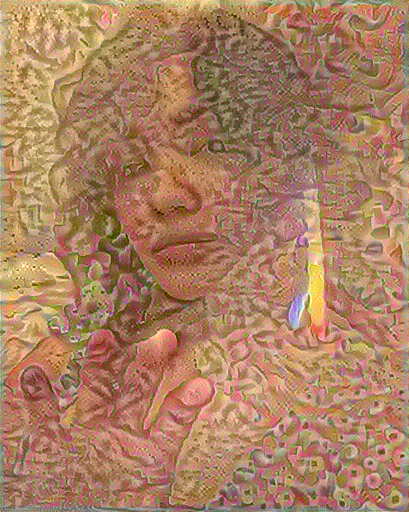

tensor.shape=TensorShape([1, 512, 409, 3])
Train step: 30
......

KeyboardInterrupt: 

In [26]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 30

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    tensor_to_image(image).save(f"training_images/epoch_{n}.png")
    print(f"Train step: {step}")
end = time.time()
print(f"Total time: {end-start}")

In [ ]:
import imageio
import glob
anim_file = 'style_transfer.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('training_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    img = imageio.imread(filename)
    writer.append_data(img)
  img = imageio.imread(filename)
  writer.append_data(img)

In [ ]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


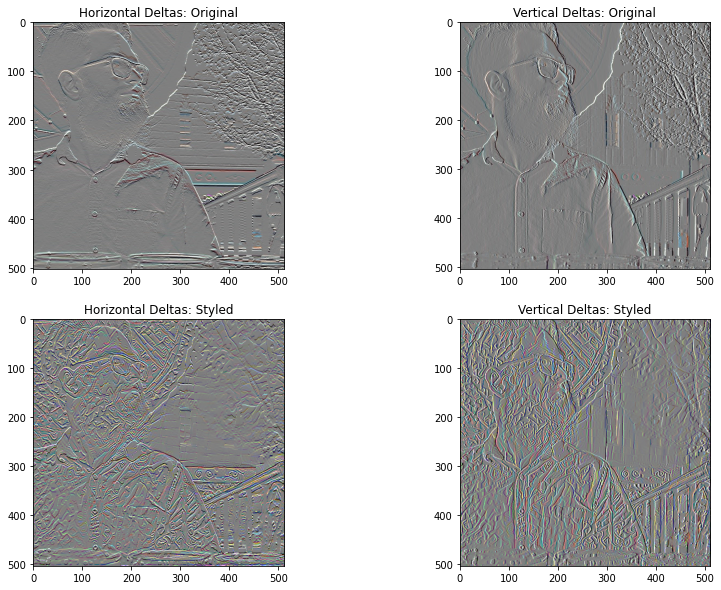

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)
print(type(image))

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

81195.375